In [9]:
%pip install eli5

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)

   -------------------------- ------------- 2/3 [eli5]
   ---------------------------------------- 3/3 [eli5]

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import print_regression_metrcis
from sklearn.svm import SVR
# 데이터 불러오기
df = pd.read_csv("mlb최종.csv", encoding="cp949")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
최적 XGBoost 모델 성능
MSE: 2.026418447494507
RMSE: 1.4235233068466187
R Squared: 0.9158909320831299


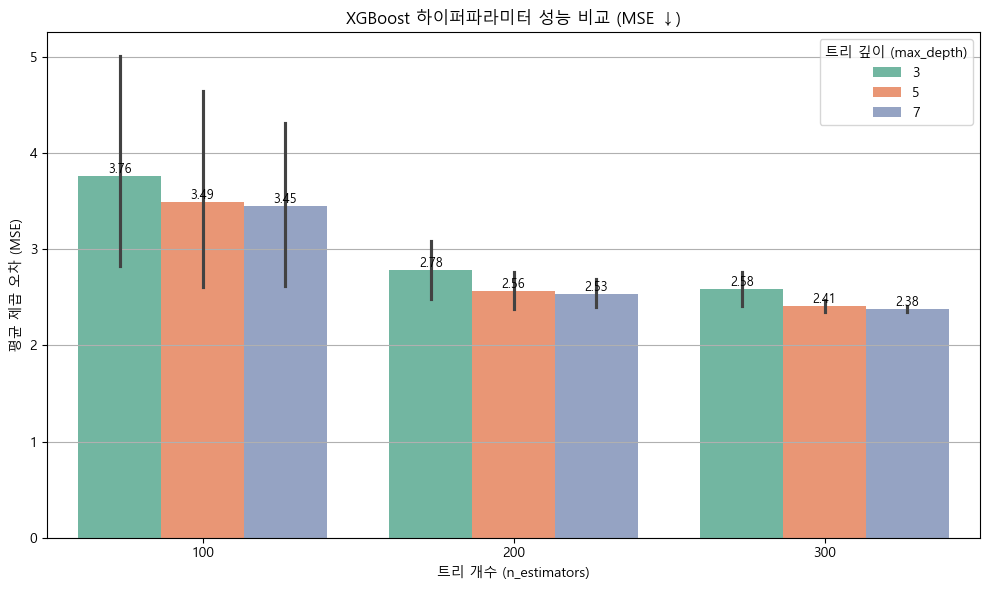

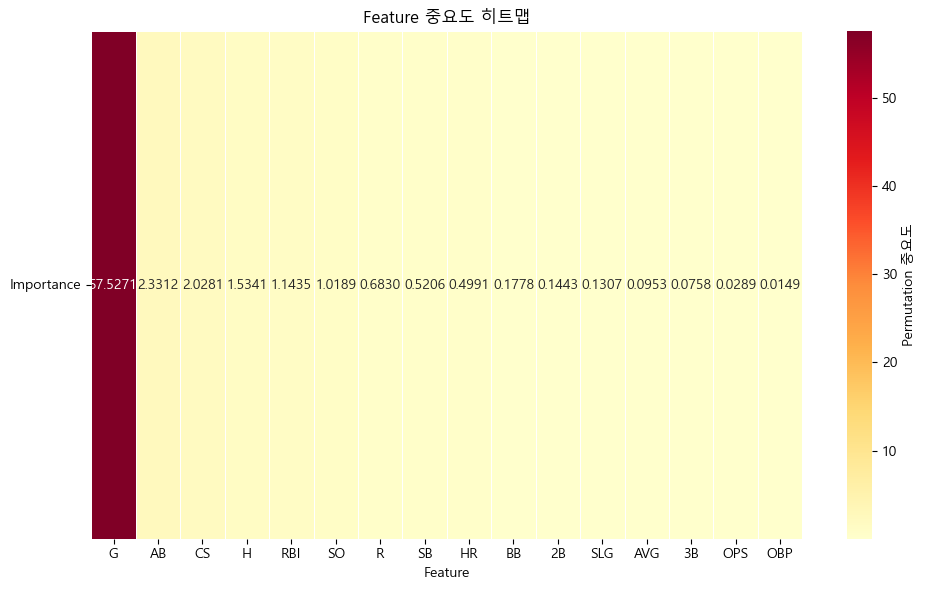

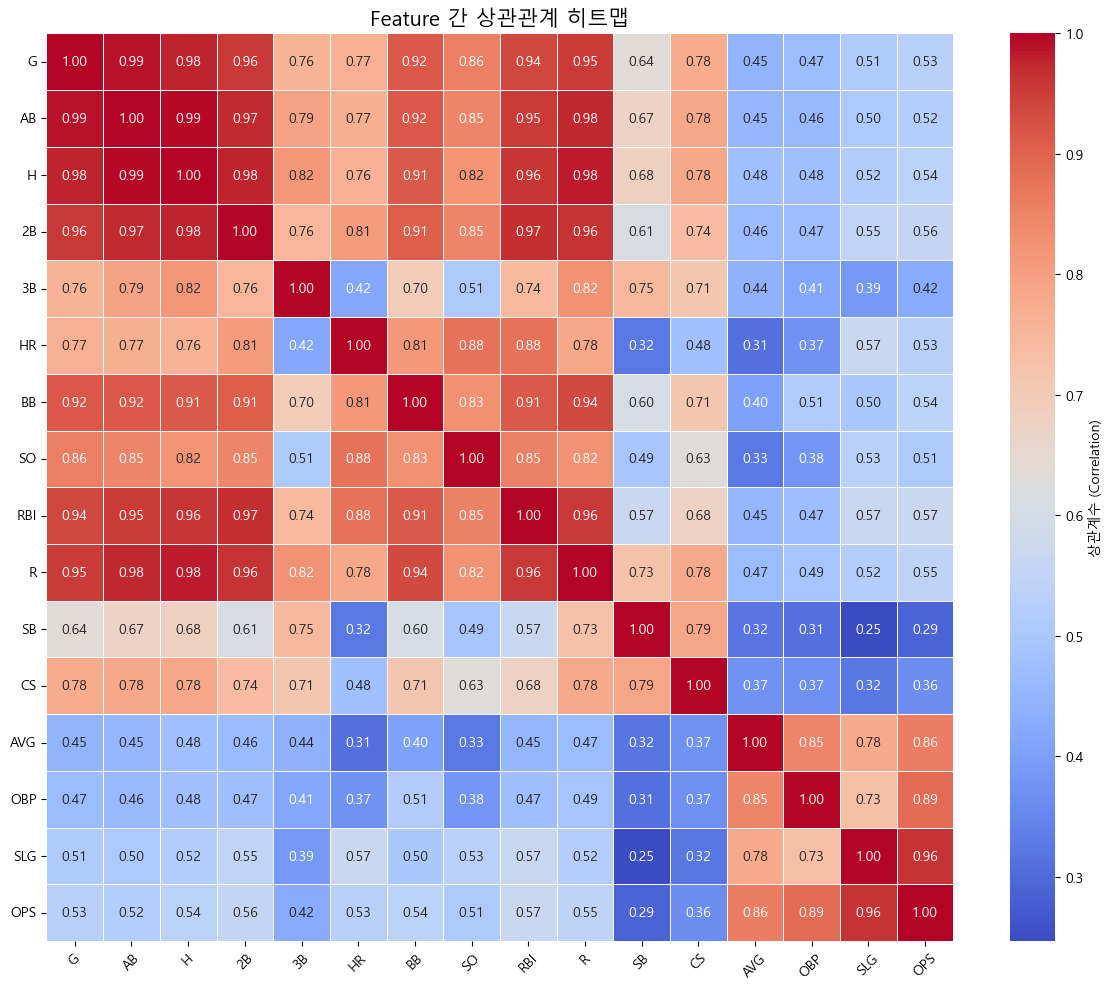

In [ ]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from metrics import print_regression_metrcis
import eli5
from eli5.sklearn import PermutationImportance

# 데이터 불러오기
df = pd.read_csv("mlb.csv", encoding="cp949")

# 타겟 생성
df['retire_age'] = df['retire_year'] - df['birth_year']
df_clean = df.dropna()

# 피처 정의
feature_cols = ['G', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'RBI', 'R', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']
X = df_clean[feature_cols]
y = df_clean['retire_age']

# 정규화 및 분할
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 후보
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV 정의
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train, y_train)

# 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# 평가
print("Best Params:", grid_search.best_params_)
print_regression_metrcis(y_val, y_pred, "최적 XGBoost 모델 성능")

# 지표 저장
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_result = {
    "Best Params": grid_search.best_params_,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

# 결과 정리
results = pd.DataFrame(grid_search.cv_results_)
results['mean_MSE'] = -results['mean_test_score']
results['param_n_estimators'] = results['param_n_estimators'].astype(str)
results['param_max_depth'] = results['param_max_depth'].astype(str)

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=results,
    x='param_n_estimators',
    y='mean_MSE',
    hue='param_max_depth',
    palette="Set2"
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

plt.title("XGBoost 하이퍼파라미터 성능 비교 (MSE ↓)")
plt.ylabel("평균 제곱 오차 (MSE)")
plt.xlabel("트리 개수 (n_estimators)")
plt.legend(title="트리 깊이 (max_depth)")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("xgb_hyperparameter_mse.png", dpi=300)
plt.show()

# 저장
with open("metrics_xgb.pkl", "wb") as f:
    pickle.dump(metrics_result, f)

# ✅ Permutation Importance 계산
perm = PermutationImportance(best_model, random_state=42, scoring='neg_mean_squared_error')
perm.fit(X_val, y_val)

# ✅ 중요도 DataFrame 생성
perm_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": perm.feature_importances_,
    "Std": perm.feature_importances_std_
}).sort_values(by="Importance", ascending=False).set_index("Feature")

# ✅ 히트맵 스타일 시각화 (값 표시 포함)
plt.figure(figsize=(10, 6))
sns.heatmap(
    perm_df[["Importance"]].T,  # 행 1개짜리 히트맵
    annot=True,
    fmt=".4f",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Permutation 중요도'}
)
plt.title("Feature 중요도 히트맵")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("permutation_importance_heatmap.png", dpi=300)
plt.show()


corr_matrix = df_clean[feature_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"label": "상관계수 (Correlation)"}
)

plt.title("Feature 간 상관관계 히트맵", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png", dpi=300)
plt.show()

corr_with_target = df_clean[feature_cols + ['retire_age']].corr()

# 전체 히트맵 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_with_target,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"label": "상관계수 (Correlation)"}
)

plt.title("Feature 간 & retire_age 상관관계 히트맵", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("feature_target_correlation_heatmap.png", dpi=300)
plt.show()

In [12]:
df_metrics = pd.DataFrame([metrics_result])  # 한 줄짜리 DataFrame
df_metrics.to_csv("metrics_rf.csv", index=False, encoding='utf-8-sig')
print("✅ metrics_rf.csv 저장 완료")

✅ metrics_rf.csv 저장 완료


In [ ]:
# 피클 불러오기 코드
with open("metrics_rf.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

# 출력
print("\n📂 저장된 평가 지표 불러오기:")
for key, value in loaded_metrics.items():
    print(f"{key}: {value}")

Note: you may need to restart the kernel to use updated packages.
